# AEESP Workshop Tutorial on WaterTAP
## Prerequisites
### * Python
### * Pyomo
### * IDAES

## Pyomo Example

$${\Huge
\begin{array}
 \text{\min} & x_1^2 + x_2^2  \\
 \text{s.t.} & x_1 + 2 x_2 \geq 1 
\end{array}}$$

### Solving Graphically

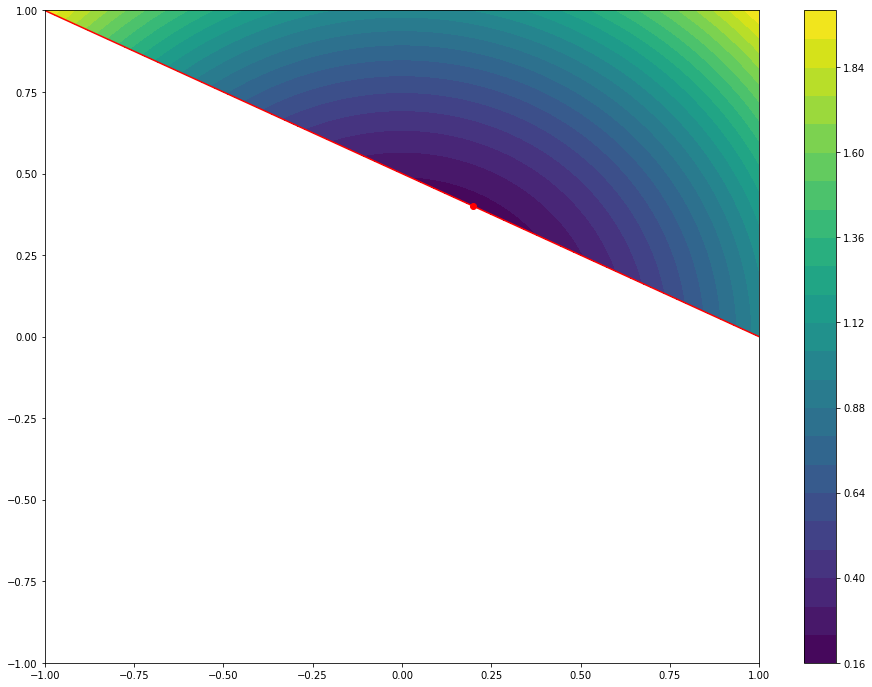

In [1]:
import matplotlib.pyplot as plt
import numpy as np

v= np.linspace(-1,1,1000)
x1, x2 = np.meshgrid(v,v)
z = x1**2 + x2**2
def _z(x1,x2):
    if x1 + 2*x2 >= 1:
        return x1**2 + x2**2
    else:
        return float('nan')
z = np.vectorize(_z)(x1,x2)
plt.figure(figsize=(16,12))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.axline((-1,1),(1,0), color='r')
plt.contourf(x1,x2,z,25)
plt.plot(0.2,0.4,'ro')
plt.colorbar()
plt.show()

### Solving with Pyomo

In [2]:
import pyomo.environ as pyo
from idaes.core.solvers import get_solver

m = pyo.ConcreteModel()
m.x = pyo.Var([1, 2], domain=pyo.Reals)
m.obj = pyo.Objective(expr=m.x[1]**2 + m.x[2]**2)
m.con = pyo.Constraint(expr=m.x[1] + 2*m.x[2] >= 1)

solver = get_solver()
results = solver.solve(m, tee=False)

if pyo.check_optimal_termination(results):
print(f"\nx1: {m.x[1].value:.2f}, x2: {m.x[2].value:.2f}, objective: {pyo.value(m.obj):.2f}")

Ipopt 3.14.4: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constrain

## Property Model Example

## Introduction to the Reverse Osmosis Unit Model
This section shows how to build, initialize, simulate, and optimize a simplified reverse osmosis (RO) unit model using WaterTAP. In this example, we will minimize the specific energy consumption of the RO unit.

### Step 1: Import libraries.

In [ ]:
# Imports from Pyomo, including "value" for getting the 
# value of Pyomo objects
from pyomo.environ import ConcreteModel, Objective, Expression, value

# Imports from IDAES
# Import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock
# Import function to get default solver
from idaes.core.solvers import get_solver
# Import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom
# Import utility function for calculating scaling factors
from idaes.core.util.scaling import calculate_scaling_factors

# Imports from WaterTAP
# Import NaCl property model
from watertap.property_models.NaCl_prop_pack import NaClParameterBlock
# Import RO model
from watertap.unit_models.reverse_osmosis_0D import (ReverseOsmosis0D,
        ConcentrationPolarizationType, MassTransferCoefficient)

### Step 2: Start building the RO model.

In [ ]:
# Create a Pyomo concrete model, flowsheet, and NaCl property parameter block.
m = ConcreteModel()
m.fs = FlowsheetBlock(default={'dynamic':False})
m.fs.properties = NaClParameterBlock()

In [ ]:
# Add an RO unit to the flowsheet.
m.fs.unit = ReverseOsmosis0D(default={
    "property_package": m.fs.properties,
    "concentration_polarization_type": ConcentrationPolarizationType.none,
    "mass_transfer_coefficient": MassTransferCoefficient.none,
    "has_pressure_change": False,
    })

### Step 3: Specify values for system variables.

In [ ]:
m.fs.unit.inlet.flow_mass_phase_comp[0, 'Liq', 'NaCl'].fix(0.035)  # mass flow rate of NaCl (kg/s)
m.fs.unit.inlet.flow_mass_phase_comp[0, 'Liq', 'H2O'].fix(0.965)   # mass flow rate of water (kg/s)
m.fs.unit.inlet.pressure[0].fix(50e5)                              # feed pressure (Pa)
m.fs.unit.inlet.temperature[0].fix(298.15)                         # feed temperature (K)
m.fs.unit.area.fix(50)                                             # membrane area (m^2)
m.fs.unit.A_comp.fix(4.2e-12)                                      # membrane water permeability (m/Pa/s)
m.fs.unit.B_comp.fix(3.5e-8)                                       # membrane salt permeability (m/s)
m.fs.unit.permeate.pressure[0].fix(101325)                         # permeate pressure (Pa)

### Step 4: Scale all variables.

In [ ]:
# Set scaling factors for component mass flowrates.
m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1, index=('Liq', 'H2O'))
m.fs.properties.set_default_scaling('flow_mass_phase_comp', 1e2, index=('Liq', 'NaCl'))

# Calculate scaling factors for all other variables.
calculate_scaling_factors(m)

### Step 5: Initialize the model.

In [ ]:
m.fs.unit.initialize()

### Step 6: Setup a solver and run a simulation.

In [ ]:
# Check that degrees of freedom = 0 before attempting simulation.
# This means that the performance of the flowsheet is completely
# determined by the system variables that were fixed above.
assert degrees_of_freedom(m) == 0

In [ ]:
# Setup solver
solver = get_solver()

In [ ]:
# Run simulation
simulation_results = solver.solve(m)

In [ ]:
# Display all results
m.fs.unit.display()

### Step 7: Unfix variables, set variable bounds, and run optimization to minimize specific energy consumption.

In [ ]:
# Unfix membrane area and feed pressure
m.fs.unit.area.unfix()                  # membrane area (m^2)
m.fs.unit.inlet.pressure[0].unfix()     # feed pressure (Pa)

In [ ]:
# Set lower and upper bounds for membrane area (m^2)
m.fs.unit.area.setlb(1)
m.fs.unit.area.setub(500)

In [ ]:
# Set lower and upper bounds for feed pressure (Pa)
m.fs.unit.inlet.pressure[0].setlb(10e5)
m.fs.unit.inlet.pressure[0].setub(80e5)

In [ ]:
# Assume 100% efficiency of pumps and ERD and no pressure losses
#--> Pump power consumption ~ Qp*Pf/3.6e6
m.fs.specific_energy_consumption = Expression(
    expr=m.fs.unit.inlet.pressure[0]/(3.6e6))

In [ ]:
# Define objective function to minimize the specific energy consumption.
m.fs.objective = Objective(expr=m.fs.specific_energy_consumption)

In [ ]:
# Set the water recovery to 50%
m.fs.unit.recovery_vol_phase[0,'Liq'].fix(0.50)

In [ ]:
# The solver will find the membrane area and 
# inlet pressure that achieve 50% recovery while minimizing
# specific energy consumption. Since we fixed the 
# volumetric water recovery, a degree of freedom 
# was removed from the model.
print(degrees_of_freedom(m))

In [ ]:
optimization_results = solver.solve(m)

In [ ]:
# membrane area of the optimized RO unit
value(m.fs.unit.area)

In [ ]:
# inlet pressure of the optimized RO unit
# value(m.fs.unit.inlet.pressure[0])
m.fs.unit.feed_side.properties[0,0].pressure.display()

In [ ]:
# the minimum specific energy consumption
m.fs.specific_energy_consumption.display()

In [ ]:
# display the overall report on the RO unit
m.fs.unit.report()

## Flowsheet Example
# ADD IMAGE OF FLOWSHEET DIAGRAM

## Import libraries.

In [ ]:
from pyomo.environ import (
    ConcreteModel,
    value,
    Constraint,
    Objective,
    Param,
    TransformationFactory,
    units,
    assert_optimal_termination,
)
from pyomo.network import Arc
from pyomo.util.check_units import assert_units_consistent
from idaes.core import FlowsheetBlock
from idaes.core.solvers import get_solver
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import solve_indexed_blocks, propagate_state
from idaes.models.unit_models import Mixer, Separator, Product, Feed
from idaes.core import UnitModelCostingBlock
import idaes.core.util.scaling as iscale
import watertap.property_models.seawater_prop_pack as props
from watertap.unit_models.reverse_osmosis_0D import (
    ReverseOsmosis0D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.unit_models.pressure_changer import Pump, EnergyRecoveryDevice
from watertap.core.util.initialization import assert_degrees_of_freedom
from watertap.costing import WaterTAPCosting

## Build the flowsheet.

In [ ]:
# flowsheet setup
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = props.SeawaterParameterBlock()
m.fs.costing = WaterTAPCosting()

# unit models
m.fs.feed = Feed(default={"property_package": m.fs.properties})
m.fs.pump = Pump(default={"property_package": m.fs.properties})
m.fs.RO = ReverseOsmosis0D(
    default={
        "property_package": m.fs.properties,
        "has_pressure_change": True,
        "pressure_change_type": PressureChangeType.calculated,
        "mass_transfer_coefficient": MassTransferCoefficient.calculated,
        "concentration_polarization_type": ConcentrationPolarizationType.calculated,
    }
)
m.fs.erd = EnergyRecoveryDevice(
    default={
        "property_package": m.fs.properties,
    },
)
m.fs.product = Product(default={"property_package": m.fs.properties})
m.fs.disposal = Product(default={"property_package": m.fs.properties})
# costing
m.fs.pump.costing = UnitModelCostingBlock(
    default={"flowsheet_costing_block": m.fs.costing}
)
m.fs.RO.costing = UnitModelCostingBlock(
    default={"flowsheet_costing_block": m.fs.costing}
)
m.fs.erd.costing = UnitModelCostingBlock(
    default={
        "flowsheet_costing_block": m.fs.costing,
        "costing_method_arguments": {
            "energy_recovery_device_type": "pressure_exchanger"
        },
    }
)
m.fs.costing.cost_process()
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_specific_energy_consumption(m.fs.product.properties[0].flow_vol)

# connections
m.fs.s01 = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)
m.fs.s02 = Arc(source=m.fs.pump.outlet, destination=m.fs.RO.inlet)
m.fs.s03 = Arc(source=m.fs.RO.permeate, destination=m.fs.product.inlet)
m.fs.s04 = Arc(source=m.fs.RO.retentate, destination=m.fs.erd.inlet)
m.fs.s05 = Arc(source=m.fs.erd.outlet, destination=m.fs.disposal.inlet)
TransformationFactory("network.expand_arcs").apply_to(m)

# scaling
# set default property values
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1, index=("Liq", "H2O"))
m.fs.properties.set_default_scaling(
    "flow_mass_phase_comp", 1e2, index=("Liq", "TDS")
)
# set unit model values
iscale.set_scaling_factor(m.fs.pump.control_volume.work, 1e-3)
iscale.set_scaling_factor(m.fs.erd.control_volume.work, 1e-3)
iscale.set_scaling_factor(m.fs.RO.area, 1e-2)
# touch properties used in specifying the model
m.fs.feed.properties[0].flow_vol_phase["Liq"]
m.fs.feed.properties[0].mass_frac_phase_comp["Liq", "TDS"]
m.fs.disposal.properties[0].flow_vol_phase["Liq"]
m.fs.disposal.properties[0].mass_frac_phase_comp["Liq", "TDS"]
# calculate and propagate scaling factors
iscale.calculate_scaling_factors(m)

## Set the specifications for simulating the flowsheet.

In [ ]:
# ---specifications---
# feed
# state variables
m.fs.feed.properties[0].pressure.fix(101325)  # feed pressure [Pa]
m.fs.feed.properties[0].temperature.fix(273.15 + 25)  # feed temperature [K]
# properties (cannot be fixed for initialization routines, must calculate the state variables)
m.fs.feed.properties.calculate_state(
    var_args={
        ("flow_vol_phase", "Liq"): 1e-3,  # feed volumetric flow rate [m3/s]
        ("mass_frac_phase_comp", ("Liq", "TDS")): 0.035,
    },  # feed TDS mass fraction [-]
    hold_state=True,  # fixes the calculated component mass flow rates
)

# high pressure pump, 2 degrees of freedom (efficiency and outlet pressure)
m.fs.pump.efficiency_pump.fix(0.80)  # pump efficiency [-]
m.fs.pump.control_volume.properties_out[0].pressure.fix(
    75e5
)  # pump outlet pressure [Pa]

# RO unit
m.fs.RO.A_comp.fix(4.2e-12)  # membrane water permeability coefficient [m/s-Pa]
m.fs.RO.B_comp.fix(3.5e-8)  # membrane salt permeability coefficient [m/s]
m.fs.RO.channel_height.fix(1e-3)  # channel height in membrane stage [m]
m.fs.RO.spacer_porosity.fix(0.97)  # spacer porosity in membrane stage [-]
m.fs.RO.permeate.pressure[0].fix(101325)  # atmospheric pressure [Pa]
# m.fs.RO.width.fix(5)  # stage width [m]
# m.fs.RO.N_Re[0, 0].fix(500)
m.fs.RO.velocity[0, 0].fix(0.15)
m.fs.RO.recovery_vol_phase[0, "Liq"].fix(0.5)

# energy recovery device, 2 degrees of freedom (efficiency and outlet pressure)
m.fs.erd.efficiency_pump.fix(0.80)  # erd efficiency [-]
m.fs.erd.control_volume.properties_out[0].pressure.fix(
    101325
)  # atmospheric outlet pressure [Pa]

# check degrees of freedom
if degrees_of_freedom(m) != 0:
    raise RuntimeError(
        "The set_operating_conditions function resulted in {} "
        "degrees of freedom rather than 0. This error suggests "
        "that too many or not enough variables are fixed for a "
        "simulation.".format(degrees_of_freedom(m))
    )

## Initialize the flowsheet.

In [ ]:
m.fs.feed.initialize()
propagate_state(m.fs.s01)
m.fs.pump.initialize()
propagate_state(m.fs.s02)
m.fs.RO.initialize()
propagate_state(m.fs.s03)
propagate_state(m.fs.s04)
m.fs.erd.initialize()
propagate_state(m.fs.s05)

m.fs.costing.initialize()

## Run the simulation and display results.

### Solve the model

In [ ]:
solver = get_solver()
results = solver.solve(m, tee=True)    
assert_optimal_termination(results)

### Display results

In [ ]:
print("\n***---Simulation results---***")
print("---system metrics---")
feed_flow_mass = sum(
    m.fs.feed.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
)
feed_mass_frac_TDS = (
    m.fs.feed.flow_mass_phase_comp[0, "Liq", "TDS"].value / feed_flow_mass
)
print("Feed: %.2f kg/s, %.0f ppm" % (feed_flow_mass, feed_mass_frac_TDS * 1e6))

prod_flow_mass = sum(
    m.fs.product.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
)
prod_mass_frac_TDS = (
    m.fs.product.flow_mass_phase_comp[0, "Liq", "TDS"].value / prod_flow_mass
)
print("Product: %.3f kg/s, %.0f ppm" % (prod_flow_mass, prod_mass_frac_TDS * 1e6))

print(
    "Volumetric recovery: %.1f%%"
    % (value(m.fs.RO.recovery_vol_phase[0, "Liq"]) * 100)
)
print(
    "Water recovery: %.1f%%"
    % (value(m.fs.RO.recovery_mass_phase_comp[0, "Liq", "H2O"]) * 100)
)
print(
    "Energy Consumption: %.1f kWh/m3"
    % value(m.fs.costing.specific_energy_consumption)
)
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

# Display decision variable results
print("---decision variables---")
print("Operating pressure %.1f bar" % (m.fs.RO.inlet.pressure[0].value / 1e5))
print(
    "Membrane\narea %.1f m2\ninlet Reynolds %.1f, inlet velocity %.1f cm/s"
    % (
        m.fs.RO.area.value,
        m.fs.RO.N_Re[0, 0].value,
        m.fs.RO.velocity[0, 0].value * 100,
    )
)

print("---system variables---")
print(
    "Pump\noutlet pressure: %.1f bar\npower %.2f kW"
    % (
        m.fs.pump.outlet.pressure[0].value / 1e5,
        m.fs.pump.work_mechanical[0].value / 1e3,
    )
)
print(
    "Membrane"
    "\naverage flux: %.1f LMH"
    "\npressure drop: %.1f bar"
    "\nmax interfacial conc %.1f ppm"
    % (
        value(m.fs.RO.flux_mass_phase_comp_avg[0, "Liq", "H2O"]) * 3600,
        m.fs.RO.deltaP[0].value / 1e5,
        m.fs.RO.feed_side.properties_interface[0, 1]
        .mass_frac_phase_comp["Liq", "TDS"]
        .value
        * 1e6,
    ))

print("---state---")
def print_state(s, b):
    flow_mass = sum(
        b.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
    )
    mass_frac_ppm = b.flow_mass_phase_comp[0, "Liq", "TDS"].value / flow_mass * 1e6
    pressure_bar = b.pressure[0].value / 1e5
    print(
        s
        + ": %.3f kg/s, %.0f ppm, %.1f bar"
        % (flow_mass, mass_frac_ppm, pressure_bar)
    )

print_state("Feed      ", m.fs.feed.outlet)
print_state("Pump out  ", m.fs.pump.outlet)
print_state("RO perm   ", m.fs.RO.permeate)
print_state("RO reten  ", m.fs.RO.retentate)

## Setup optimization.

In [ ]:
# objective
m.fs.objective = Objective(expr=m.fs.costing.LCOW)

# unfix decision variables and add bounds
# pump 1 and pump 2
m.fs.pump.control_volume.properties_out[0].pressure.unfix()
m.fs.pump.control_volume.properties_out[0].pressure.setlb(10e5)
m.fs.pump.control_volume.properties_out[0].pressure.setub(85e5)
m.fs.pump.deltaP.setlb(0)

# RO
# m.fs.RO.N_Re[0, 0].unfix()
# m.fs.RO.N_Re.setlb(1)
# m.fs.RO.N_Re.setub(1000)
m.fs.RO.velocity[0, 0].unfix()
m.fs.RO.velocity.setlb(0.01)
m.fs.RO.velocity.setub(1)
m.fs.RO.area.setlb(1)
m.fs.RO.area.setub(150)

# additional specifications
m.fs.max_product_salinity = Param(
    initialize=500e-6, mutable=True, units=units.dimensionless
)  # product TDS mass fraction [-]
m.fs.max_pressure = Param(
    initialize=85e5, mutable=True, units=units.Pa
)  # product TDS mass fraction [-]
m.fs.minimum_water_flux = Param(
    initialize=1.0 / 3600.0, mutable=True, units=units.kg / units.m**2 / units.s
)  # minimum water flux [kg/m2-s]

# additional constraints
m.fs.eq_product_quality = Constraint(
    expr=m.fs.product.properties[0].mass_frac_phase_comp["Liq", "TDS"]
    <= m.fs.max_product_salinity
)
iscale.constraint_scaling_transform(
    m.fs.eq_product_quality, 1e3
)  # scaling constraint
m.fs.eq_max_pressure = Constraint(
    expr=m.fs.RO.feed_side.properties[0, 0].pressure <= m.fs.max_pressure
)
iscale.constraint_scaling_transform(
    m.fs.eq_max_pressure, 1e-6
)  # scaling constraint
m.fs.eq_minimum_water_flux = Constraint(
    expr=m.fs.RO.flux_mass_phase_comp[0, 1, "Liq", "H2O"] >= m.fs.minimum_water_flux
)

# ---checking model---
assert_degrees_of_freedom(m, 2)

## Solve the optimization problem and display results.

In [ ]:
results = solver.solve(m, tee=True)    
assert_optimal_termination(results)

In [ ]:
print("\n***---Optimization results---***")
print("---system metrics---")
feed_flow_mass = sum(
    m.fs.feed.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
)
feed_mass_frac_TDS = (
    m.fs.feed.flow_mass_phase_comp[0, "Liq", "TDS"].value / feed_flow_mass
)
print("Feed: %.2f kg/s, %.0f ppm" % (feed_flow_mass, feed_mass_frac_TDS * 1e6))

prod_flow_mass = sum(
    m.fs.product.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
)
prod_mass_frac_TDS = (
    m.fs.product.flow_mass_phase_comp[0, "Liq", "TDS"].value / prod_flow_mass
)
print("Product: %.3f kg/s, %.0f ppm" % (prod_flow_mass, prod_mass_frac_TDS * 1e6))

print(
    "Volumetric recovery: %.1f%%"
    % (value(m.fs.RO.recovery_vol_phase[0, "Liq"]) * 100)
)
print(
    "Water recovery: %.1f%%"
    % (value(m.fs.RO.recovery_mass_phase_comp[0, "Liq", "H2O"]) * 100)
)
print(
    "Energy Consumption: %.1f kWh/m3"
    % value(m.fs.costing.specific_energy_consumption)
)
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

# Display decision variable results
print("---decision variables---")
print("Operating pressure %.1f bar" % (m.fs.RO.inlet.pressure[0].value / 1e5))
print(
    "Membrane\narea %.1f m2\ninlet Reynolds %.1f, inlet velocity %.1f cm/s"
    % (
        m.fs.RO.area.value,
        m.fs.RO.N_Re[0, 0].value,
        m.fs.RO.velocity[0, 0].value * 100,
    )
)

print("---system variables---")
print(
    "Pump\noutlet pressure: %.1f bar\npower %.2f kW"
    % (
        m.fs.pump.outlet.pressure[0].value / 1e5,
        m.fs.pump.work_mechanical[0].value / 1e3,
    )
)
print(
    "Membrane"
    "\naverage flux: %.1f LMH"
    "\npressure drop: %.1f bar"
    "\nmax interfacial conc %.1f ppm"
    % (
        value(m.fs.RO.flux_mass_phase_comp_avg[0, "Liq", "H2O"]) * 3600,
        m.fs.RO.deltaP[0].value / 1e5,
        m.fs.RO.feed_side.properties_interface[0, 1]
        .mass_frac_phase_comp["Liq", "TDS"]
        .value
        * 1e6,
    ))

print("---state---")
def print_state(s, b):
    flow_mass = sum(
        b.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
    )
    mass_frac_ppm = b.flow_mass_phase_comp[0, "Liq", "TDS"].value / flow_mass * 1e6
    pressure_bar = b.pressure[0].value / 1e5
    print(
        s
        + ": %.3f kg/s, %.0f ppm, %.1f bar"
        % (flow_mass, mass_frac_ppm, pressure_bar)
    )

print_state("Feed      ", m.fs.feed.outlet)
print_state("Pump out  ", m.fs.pump.outlet)
print_state("RO perm   ", m.fs.RO.permeate)
print_state("RO reten  ", m.fs.RO.retentate)

## Change the membrane capital cost and try optimizing again.

### Change membrane cost and solve.

In [ ]:
m.fs.costing.reverse_osmosis_membrane_cost.fix(60)
results = solver.solve(m, tee=True)    
assert_optimal_termination(results)

### Display new optimization results

In [ ]:
print("\n***---Optimization results---***")
print("---system metrics---")
feed_flow_mass = sum(
    m.fs.feed.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
)
feed_mass_frac_TDS = (
    m.fs.feed.flow_mass_phase_comp[0, "Liq", "TDS"].value / feed_flow_mass
)
print("Feed: %.2f kg/s, %.0f ppm" % (feed_flow_mass, feed_mass_frac_TDS * 1e6))

prod_flow_mass = sum(
    m.fs.product.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
)
prod_mass_frac_TDS = (
    m.fs.product.flow_mass_phase_comp[0, "Liq", "TDS"].value / prod_flow_mass
)
print("Product: %.3f kg/s, %.0f ppm" % (prod_flow_mass, prod_mass_frac_TDS * 1e6))

print(
    "Volumetric recovery: %.1f%%"
    % (value(m.fs.RO.recovery_vol_phase[0, "Liq"]) * 100)
)
print(
    "Water recovery: %.1f%%"
    % (value(m.fs.RO.recovery_mass_phase_comp[0, "Liq", "H2O"]) * 100)
)
print(
    "Energy Consumption: %.1f kWh/m3"
    % value(m.fs.costing.specific_energy_consumption)
)
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

# Display decision variable results
print("---decision variables---")
print("Operating pressure %.1f bar" % (m.fs.RO.inlet.pressure[0].value / 1e5))
print(
    "Membrane\narea %.1f m2\ninlet Reynolds %.1f, inlet velocity %.1f cm/s"
    % (
        m.fs.RO.area.value,
        m.fs.RO.N_Re[0, 0].value,
        m.fs.RO.velocity[0, 0].value * 100,
    )
)

print("---system variables---")
print(
    "Pump\noutlet pressure: %.1f bar\npower %.2f kW"
    % (
        m.fs.pump.outlet.pressure[0].value / 1e5,
        m.fs.pump.work_mechanical[0].value / 1e3,
    )
)
print(
    "Membrane"
    "\naverage flux: %.1f LMH"
    "\npressure drop: %.1f bar"
    "\nmax interfacial conc %.1f ppm"
    % (
        value(m.fs.RO.flux_mass_phase_comp_avg[0, "Liq", "H2O"]) * 3600,
        m.fs.RO.deltaP[0].value / 1e5,
        m.fs.RO.feed_side.properties_interface[0, 1]
        .mass_frac_phase_comp["Liq", "TDS"]
        .value
        * 1e6,
    ))

print("---state---")
def print_state(s, b):
    flow_mass = sum(
        b.flow_mass_phase_comp[0, "Liq", j].value for j in ["H2O", "TDS"]
    )
    mass_frac_ppm = b.flow_mass_phase_comp[0, "Liq", "TDS"].value / flow_mass * 1e6
    pressure_bar = b.pressure[0].value / 1e5
    print(
        s
        + ": %.3f kg/s, %.0f ppm, %.1f bar"
        % (flow_mass, mass_frac_ppm, pressure_bar)
    )

print_state("Feed      ", m.fs.feed.outlet)
print_state("Pump out  ", m.fs.pump.outlet)
print_state("RO perm   ", m.fs.RO.permeate)
print_state("RO reten  ", m.fs.RO.retentate)